**Handles large computes associated with mrvi_da_test.ipynb**
- run on colab w/ gpu, not mark's laptop

In [ ]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

copy over pre-run model (only 1x)

In [ ]:
zip_path='/content/drive/MyDrive/Copy of mrvi_model_cd4_memory_plus_hvg.zip'

if not os.path.isfile('/content/drive/MyDrive/shared/mgiammar_tests/cs294_hw/mrvi_model_cd4_memory_plus_hvg/adata.h5ad'):
    import zipfile
    import os


    output_dir = '/content/drive/MyDrive'
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(output_dir)

    print(f"Successfully unzipped '{zip_path}' to '{os.path.abspath(output_dir)}'")


# Load model, calc embeddings

In [ ]:
from scvi.external import TorchMRVI
import os, pickle
modelpath = '/content/drive/MyDrive/project_output/mrvi_model_cd4_memory_plus_hvg'
model = TorchMRVI.load(modelpath, accelerator = 'gpu')


## ran these 1x, just load in now
#modelpath = '/content/drive/MyDrive/shared/mgiammar_tests/cs294_hw/mrvi_model_cd4_memory_plus_hvg'
# z = model.get_latent_representation(give_z=True)
# u = model.get_latent_representation()
# model.adata.obsm['u'] = u
# model.adata.obsm['z'] = z
# savedir = '/content/drive/MyDrive/project_output/mrvi_model_cd4_memory_plus_hvg'
# os.mkdir(savedir)
# model.save(
#     savedir,
#     overwrite=True,
#     save_anndata=True,
# )
# output_dir = '/content/drive/MyDrive/project_output/'
# output_file = os.path.join(output_dir, 'u_embeddings.pkl')

# with open(output_file, 'wb') as f:
#     pickle.dump(model.adata.obsm['u'], f)

INFO     File /content/drive/MyDrive/project_output/mrvi_model_cd4_memory_plus_hvg/model.pt already downloaded     


add leiden clusters (created in other notebook with cugraph)

In [ ]:
import pandas as pd
partitions = pd.read_csv('/content/drive/MyDrive/project_output/parts.res0_2.tsv', sep = '\t', index_col = 0)
model.adata.obs['partition'] = partitions['partition'].to_numpy()

# run UMAP

In [ ]:
from cuml.manifold import UMAP

reducer = UMAP(n_neighbors=15, n_components=2, verbose=True, min_dist=0.3)
embedding_ = reducer.fit_transform(model.adata.obsm['u'])
z_embedding_ = reducer.fit_transform(model.adata.obsm['z'])
model.adata.obsm['umap']  = embedding_

[2025-12-19 14:10:34.869] [CUML] [debug] Computing KNN Graph
[2025-12-19 14:11:02.851] [CUML] [debug] Computing fuzzy simplicial set
[2025-12-19 14:11:09.230] [CUML] [debug] Computing KNN Graph
[2025-12-19 14:11:36.936] [CUML] [debug] Computing fuzzy simplicial set


In [ ]:
import pandas as pd
pd.DataFrame(embedding_, index = model.adata.obs.index,
             columns = ['U_UMAP0', 'U_UMAP1']).to_csv('/content/drive/MyDrive/project_output/u_UMAP.csv')

pd.DataFrame(z_embedding_, index = model.adata.obs.index,
             columns = ['Z_UMAP0', 'Z_UMAP1']).to_csv('/content/drive/MyDrive/project_output/z_UMAP.csv')

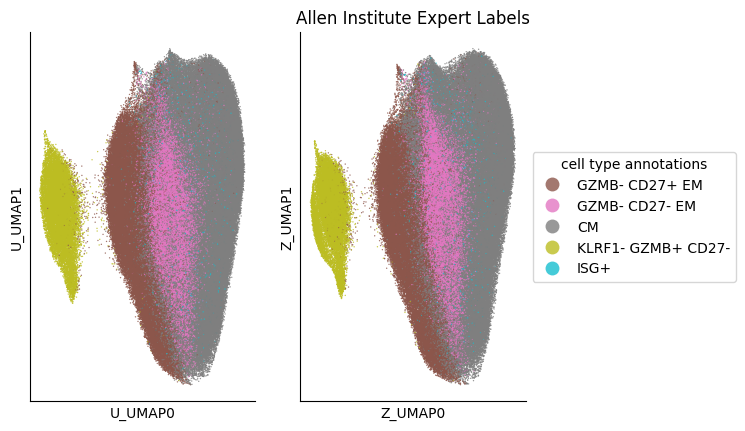

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
data = model.adata.obs.copy()
data['U_UMAP0'] = embedding_[:,0]
data['U_UMAP1'] = embedding_[:,1]
data['Z_UMAP0'] = z_embedding_[:,0]
data['Z_UMAP1'] = z_embedding_[:,1]
data['cell_type'] = data['AIFI_L3'].astype('str').replace(\
    {'GZMB- CD27+ EM CD4 T cell': 'GZMB- CD27+ EM',
     'GZMB- CD27- EM CD4 T cell':'GZMB- CD27- EM',
     'CM CD4 T cell':'CM',
     'KLRF1- GZMB+ CD27- memory CD4 T cell': 'KLRF1- GZMB+ CD27-',
     'ISG+ memory CD4 T cell': 'ISG+'})
aifi_colors = dict(zip(data['cell_type'].unique().tolist(),
['C5', 'C6', 'C7', 'C8', 'C9']))
fig, ax = plt.subplots(1,2)
sns.despine()
sns.scatterplot(data = data.iloc[::10], x = 'U_UMAP0',
                y = 'U_UMAP1', hue = 'cell_type',
                alpha = 0.8, edgecolor = 'none', ax = ax[0],
                palette=aifi_colors,s=1, legend = False)
sns.scatterplot(data = data.iloc[::10], x = 'Z_UMAP0',
                y = 'Z_UMAP1', hue = 'cell_type',
                alpha = 0.8, edgecolor = 'none', ax = ax[1],
                palette=aifi_colors,s=1)
# Make legend marker size large
legend = ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), scatterpoints=1,
 markerscale=10, title = 'cell type annotations')

sns.despine()
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.xticks([])
plt.yticks([])
plt.title('Allen Institute Expert Labels')

plt.show()





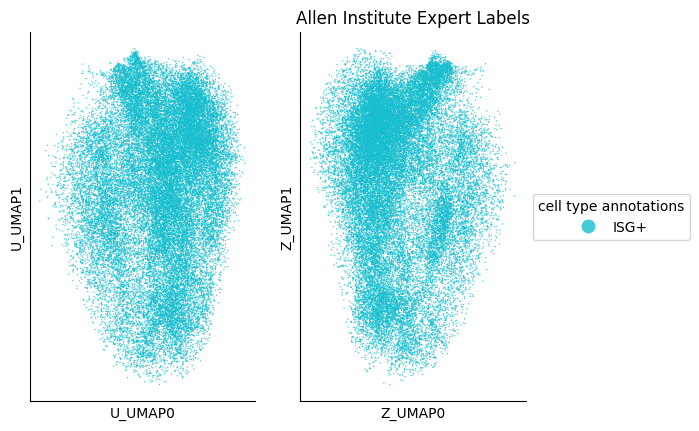

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
fig, ax = plt.subplots(1,2)
sns.despine()
sns.scatterplot(data = data[data['cell_type'] =='ISG+'], x = 'U_UMAP0',
                y = 'U_UMAP1', hue = 'cell_type',
                alpha = 0.8, edgecolor = 'none', ax = ax[0],
                palette=aifi_colors,s=1, legend = False)
sns.scatterplot(data = data[data['cell_type'] =='ISG+'], x = 'Z_UMAP0',
                y = 'Z_UMAP1', hue = 'cell_type',
                alpha = 0.8, edgecolor = 'none', ax = ax[1],
                palette=aifi_colors,s=1)
# Make legend marker size large
legend = ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), scatterpoints=1,
 markerscale=10, title = 'cell type annotations')

sns.despine()
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.xticks([])
plt.yticks([])
plt.title('Allen Institute Expert Labels')

plt.show()





# Differential abundance testing

In [ ]:
model.adata.obs['flu_sample'] = model.adata.obs['sample.visitName'].apply(lambda x: \
                'Day 7' if x in ['Flu Year 1 Day 7', 'Flu Year 2 Day 7',
        'Flu Year 3 Day 7'] else 'Day 90' if x in ['Flu Year 1 Day 90',
        'Flu Year 2 Day 90', 'Flu Year 3 Day 90'] else 'Day 0')
model.sample_info['flu_sample'] = model.sample_info['sample.visitName'].apply(lambda x: \
                'Day 7' if x in ['Flu Year 1 Day 7', 'Flu Year 2 Day 7',
        'Flu Year 3 Day 7'] else 'Day 90' if x in ['Flu Year 1 Day 90',
        'Flu Year 2 Day 90', 'Flu Year 3 Day 90'] else 'Day 0')
model.sample_info["flu_sample"] = model.sample_info['flu_sample'].astype('category')

**model 1: young vs old, baseline samples**

In [ ]:
import pickle
sample_cov_keys=['subject.ageGroup']
model.sample_info["subject.ageGroup"] = model.sample_info["subject.ageGroup"].cat.reorder_categories(
    ["Sound Life Young Adult", "Sound Life Older Adult"])

old_young_da = model.differential_abundance( sample_cov_keys=sample_cov_keys,
                adata = model.adata[model.adata.obs[(model.adata.obs['flu_sample']=='Day 0')].index, :].copy(),
                batch_size=512)

old_log_probs = old_young_da['subject.ageGroup_log_probs'].loc[{"subject.ageGroup": "Sound Life Older Adult"}]
young_log_probs = old_young_da['subject.ageGroup_log_probs'].loc[{"subject.ageGroup": "Sound Life Young Adult"}]
old_young_log_prob_ratio = old_log_probs - young_log_probs
with open('/content/drive/MyDrive/project_output/young_old_da_model.pkl', 'wb') as f:
    pickle.dump(old_young_da, f)

In [ ]:
with open('/content/drive/MyDrive/project_output/young_old_da_model.pkl', 'rb') as f:
    old_young_da = pickle.load(f)
old_log_probs = old_young_da['subject.ageGroup_log_probs'].loc[{"subject.ageGroup": "Sound Life Older Adult"}]
young_log_probs = old_young_da['subject.ageGroup_log_probs'].loc[{"subject.ageGroup": "Sound Life Young Adult"}]
old_young_log_prob_ratio = old_log_probs - young_log_probs

In [ ]:
plotdata = model.adata[model.adata.obs[(model.adata.obs['flu_sample']=='Day 0')].index, :].copy()
plotdata.obs["old_DA_lfc"] = old_young_log_prob_ratio.values
plotdata.obs['UMAP0'] = plotdata.obsm['umap'][:,0]
plotdata.obs['UMAP1'] = plotdata.obsm['umap'][:,1]


In [ ]:
plotdata.obs.groupby('AIFI_L3')['old_DA_lfc'].median()

/tmp/ipython-input-1730303868.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  plotdata.obs.groupby('AIFI_L3')['old_DA_lfc'].median()


,old_DA_lfc
AIFI_L3,
CM CD4 T cell,0.102038
GZMB- CD27+ EM CD4 T cell,-0.011799
GZMB- CD27- EM CD4 T cell,-0.038566
ISG+ memory CD4 T cell,0.181435
KLRF1- GZMB+ CD27- memory CD4 T cell,0.183631


In [ ]:
plotdata.obs.groupby('partition')['old_DA_lfc'].median()

,old_DA_lfc
partition,
0,0.120707
1,-0.133892
2,0.341137
3,-0.047668
4,0.187394


<Axes: xlabel='partition', ylabel='old_DA_lfc'>

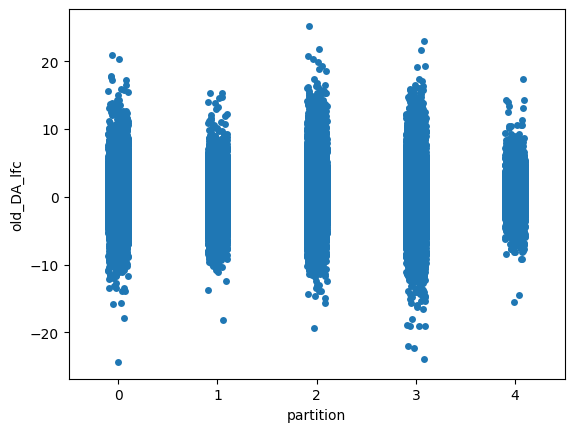

In [ ]:
sns.stripplot(data = plotdata.obs[::2], x = 'partition', y = 'old_DA_lfc')

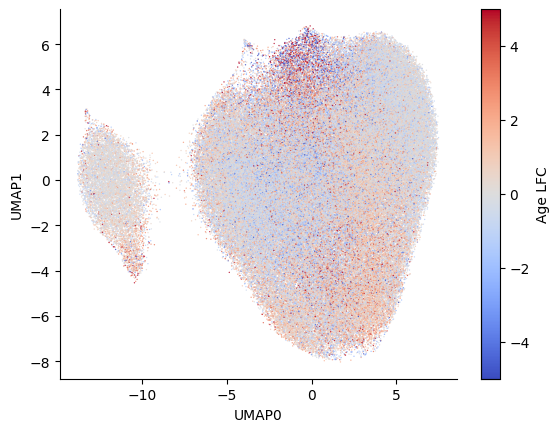

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots()
scatter = sns.scatterplot(data = plotdata.obs.iloc[::10],
                x = 'UMAP0', y= 'UMAP1', c = plotdata.obs.iloc[::10]['old_DA_lfc'],
                s=1, alpha=.8, legend=False, edgecolor='none', ax = ax, vmin=-5, vmax=5, cmap='coolwarm')
# Manually create the colorbar
norm = plt.Normalize(vmin=-5, vmax=5)
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
sm.set_array(plotdata.obs.iloc[::10]['old_DA_lfc'])
fig.colorbar(sm, ax=ax, label='Age LFC')
sns.despine()
plt.show()

# Differential expression testing

relabel metadata

In [ ]:
model.adata.obs['flu_sample'] = model.adata.obs['sample.visitName'].apply(lambda x: \
                'Day 7' if x in ['Flu Year 1 Day 7', 'Flu Year 2 Day 7',
        'Flu Year 3 Day 7'] else 'Day 90' if x in ['Flu Year 1 Day 90',
        'Flu Year 2 Day 90', 'Flu Year 3 Day 90'] else 'Day 0')
model.sample_info['flu_sample'] = model.sample_info['sample.visitName'].apply(lambda x: \
                'Day 7' if x in ['Flu Year 1 Day 7', 'Flu Year 2 Day 7',
        'Flu Year 3 Day 7'] else 'Day 90' if x in ['Flu Year 1 Day 90',
        'Flu Year 2 Day 90', 'Flu Year 3 Day 90'] else 'Day 0')
model.sample_info["flu_sample"] = model.sample_info['flu_sample'].astype('category')

Test for differential expression between old and young age groups, at baseline. Not sure if running all cell types together vs separate matters, but doing it both ways.

**Note:** trying to store LFCs (to pick the genes driving the differences) runs out of mem.

In [ ]:
sample_cov_keys=['subject.ageGroup']
model.sample_info["subject.ageGroup"] = model.sample_info["subject.ageGroup"].cat.reorder_categories(
    ["Sound Life Young Adult", "Sound Life Older Adult"])

per_type_results = {}
for cell_type in model.adata.obs['AIFI_L3'].unique():
  print(cell_type)
  per_type_results[cell_type] = model.differential_expression(
      sample_cov_keys=sample_cov_keys,
      store_lfc=False, batch_size=256,
      adata = model.adata[model.adata.obs[(model.adata.obs['flu_sample']=='Day 0') & \
                  (model.adata.obs['AIFI_L3']==cell_type)].index, :],
      use_vmap=False
  )
  with open('/content/drive/MyDrive/project_output/per_type_models.pkl', 'wb') as f:
    pickle.dump(per_type_results, f)
per_type_results['all'] = model.differential_expression(
      sample_cov_keys=sample_cov_keys,
      store_lfc=False, batch_size=256,
      adata = model.adata[model.adata.obs[(model.adata.obs['flu_sample']=='Day 0')].index, :],
      use_vmap=False,)

with open('/content/drive/MyDrive/project_output/per_type_models.pkl', 'wb') as f:
    pickle.dump(per_type_results, f)


Do the same thing for the pre-post flu shot samples

In [ ]:
sample_cov_keys=['flu_sample']
model.sample_info["flu_sample"] = model.sample_info["flu_sample"].cat.reorder_categories(
    ["Day 0", "Day 7", "Day 90"])

flu_results = {}
for age in model.adata.obs['subject.ageGroup'].unique():
  flu_results[age] = {}
  for cell_type in model.adata.obs['AIFI_L3'].unique():
    print(cell_type)
    flu_results[age][cell_type] = model.differential_expression(
        sample_cov_keys=sample_cov_keys,
        store_lfc=False, batch_size=256,
        adata = model.adata[model.adata.obs[(model.adata.obs['flu_sample']!='Day 90') & \
                  (model.adata.obs['AIFI_L3']==cell_type) & \
                (model.adata.obs['subject.ageGroup']==age)].index, :]
    )
    with open('/content/drive/MyDrive/project_output/flu_models.pkl', 'wb') as f:
      pickle.dump(flu_results, f)
  # run all cell types
  flu_results[age]['all'] = model.differential_expression(
      sample_cov_keys=sample_cov_keys,
      store_lfc=False, batch_size=256,
      adata = model.adata[model.adata.obs[(model.adata.obs['flu_sample']!='Day 90') & \
              (model.adata.obs['subject.ageGroup']==age)].index, :]
  )
  with open('/content/drive/MyDrive/project_output/flu_models.pkl', 'wb') as f:
      pickle.dump(flu_results, f)
sample_cov_keys=['flu_sample', 'subject.ageGroup']
flu_results['all'] = model.differential_expression(
      sample_cov_keys=sample_cov_keys,
      store_lfc=False, batch_size=256,
      adata = model.adata[model.adata.obs[(model.adata.obs['flu_sample']!='Day 90')].index, :]
)
with open('/content/drive/MyDrive/project_output/flu_models.pkl', 'wb') as f:
    pickle.dump(flu_results, f)


GZMB- CD27+ EM CD4 T cell


/usr/local/lib/python3.12/dist-packages/scvi/external/mrvi_torch/_model.py:1247: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["_indices"] = np.arange(adata.n_obs).astype(int)


INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 850/850 [02:08<00:00,  6.63it/s]


GZMB- CD27- EM CD4 T cell


/usr/local/lib/python3.12/dist-packages/scvi/external/mrvi_torch/_model.py:1247: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["_indices"] = np.arange(adata.n_obs).astype(int)


INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 705/705 [01:46<00:00,  6.63it/s]


CM CD4 T cell


/usr/local/lib/python3.12/dist-packages/scvi/external/mrvi_torch/_model.py:1247: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["_indices"] = np.arange(adata.n_obs).astype(int)


INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 1841/1841 [04:37<00:00,  6.64it/s]


KLRF1- GZMB+ CD27- memory CD4 T cell
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


/usr/local/lib/python3.12/dist-packages/scvi/external/mrvi_torch/_model.py:1247: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["_indices"] = np.arange(adata.n_obs).astype(int)
/usr/local/lib/python3.12/dist-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 25 in adata.obs['_scvi_sample'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
100%|██████████| 159/159 [00:23<00:00,  6.64it/s]


ISG+ memory CD4 T cell
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


/usr/local/lib/python3.12/dist-packages/scvi/external/mrvi_torch/_model.py:1247: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["_indices"] = np.arange(adata.n_obs).astype(int)
100%|██████████| 46/46 [00:06<00:00,  6.62it/s]
/usr/local/lib/python3.12/dist-packages/scvi/external/mrvi_torch/_model.py:1247: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["_indices"] = np.arange(adata.n_obs).astype(int)


INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 3600/3600 [09:01<00:00,  6.65it/s]


GZMB- CD27+ EM CD4 T cell


/usr/local/lib/python3.12/dist-packages/scvi/external/mrvi_torch/_model.py:1247: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["_indices"] = np.arange(adata.n_obs).astype(int)


INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 1016/1016 [02:32<00:00,  6.65it/s]


GZMB- CD27- EM CD4 T cell


/usr/local/lib/python3.12/dist-packages/scvi/external/mrvi_torch/_model.py:1247: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["_indices"] = np.arange(adata.n_obs).astype(int)


INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 874/874 [02:12<00:00,  6.62it/s]


CM CD4 T cell


/usr/local/lib/python3.12/dist-packages/scvi/external/mrvi_torch/_model.py:1247: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["_indices"] = np.arange(adata.n_obs).astype(int)


INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 2456/2456 [06:09<00:00,  6.64it/s]


KLRF1- GZMB+ CD27- memory CD4 T cell


/usr/local/lib/python3.12/dist-packages/scvi/external/mrvi_torch/_model.py:1247: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["_indices"] = np.arange(adata.n_obs).astype(int)


INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


/usr/local/lib/python3.12/dist-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 83 in adata.obs['_scvi_sample'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/usr/local/lib/python3.12/dist-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 37 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
100%|██████████| 334/334 [00:50<00:00,  6.63it/s]


ISG+ memory CD4 T cell
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


/usr/local/lib/python3.12/dist-packages/scvi/external/mrvi_torch/_model.py:1247: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["_indices"] = np.arange(adata.n_obs).astype(int)
/usr/local/lib/python3.12/dist-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 71 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
100%|██████████| 63/63 [00:09<00:00,  6.70it/s]
/usr/local/lib/python3.12/dist-packages/scvi/external/mrvi_torch/_model.py:1247: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["_indices"] = np.arange(adata.n_obs).astype(int)


INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 4741/4741 [11:53<00:00,  6.65it/s]
/usr/local/lib/python3.12/dist-packages/scvi/external/mrvi_torch/_model.py:1247: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["_indices"] = np.arange(adata.n_obs).astype(int)


INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 8340/8340 [21:17<00:00,  6.53it/s]


## plots for old vs young

In [ ]:
with open('/content/drive/MyDrive/project_output/per_type_models.pkl', 'rb') as f:
    per_type_results = pickle.load( f)

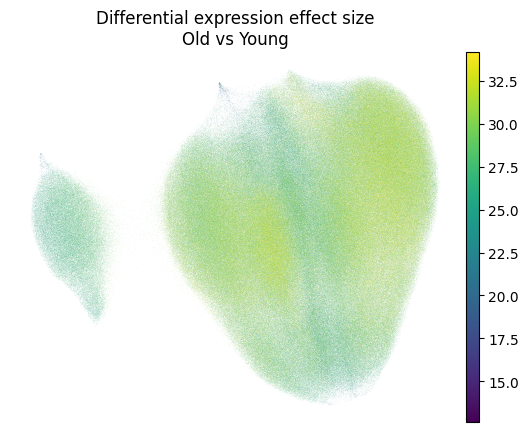

In [ ]:
import scanpy as sc
import numpy as np

test_adata = model.adata[model.adata.obs[(model.adata.obs['flu_sample']=='Day 0')].index, :]

test_adata.obs['old_young_eff_size'] = per_type_results['all'].sel(\
                                    covariate='subject.ageGroup_Sound Life Older Adult')['effect_size']
test_adata.obs['cell type'] = test_adata.obs['AIFI_L3'].apply(lambda x: x[:-11])
sc.pl.umap(
    test_adata,
    color=["old_young_eff_size"],
    frameon=False,
    ncols=1,
    vmax=np.quantile(per_type_results['all'].effect_size.values, 0.95),
    cmap="viridis", title = 'Differential expression effect size\nOld vs Young'
)

/tmp/ipython-input-1602850917.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  celltype_order = test_adata.obs.groupby('cell type')['old_young_eff_size'].mean().sort_values().index.tolist()


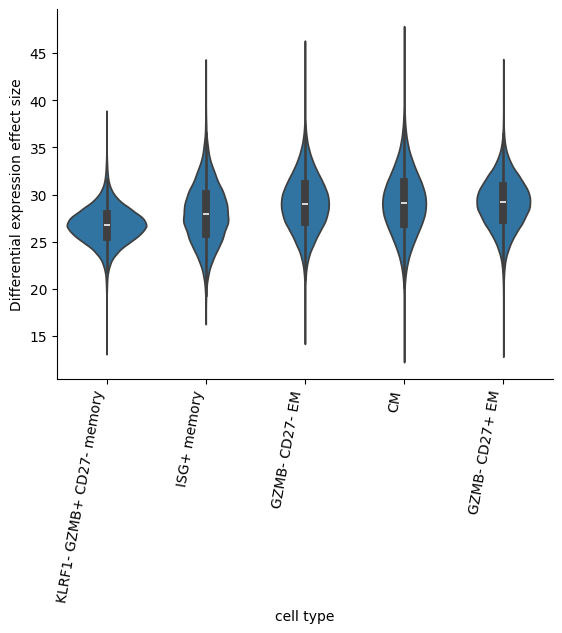

In [ ]:
fig, ax = plt.subplots()
celltype_order = test_adata.obs.groupby('cell type')['old_young_eff_size'].mean().sort_values().index.tolist()
sns.violinplot(
    data=test_adata.obs,
    x='cell type',
    y='old_young_eff_size',
    order=celltype_order,
    ax=ax)
sns.despine()
plt.xticks(ha='right', rotation = 80)
plt.ylabel('Differential expression effect size')
plt.show()

## plots for pre vs post flu shot

In [ ]:
with open('/content/drive/MyDrive/project_output/flu_models.pkl', 'rb') as f:
    flu_results = pickle.load(f)

In [ ]:
flu_results['Sound Life Young Adult']['all'].covariate

<xarray.DataArray 'covariate' (covariate: 2)> Size: 136B
array(['flu_sample_Day 7', 'flu_sample_Day 90'], dtype='<U17')
Coordinates:
  * covariate  (covariate) <U17 136B 'flu_sample_Day 7' 'flu_sample_Day 90'

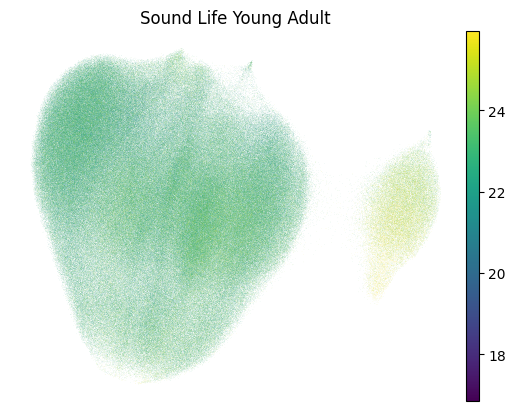

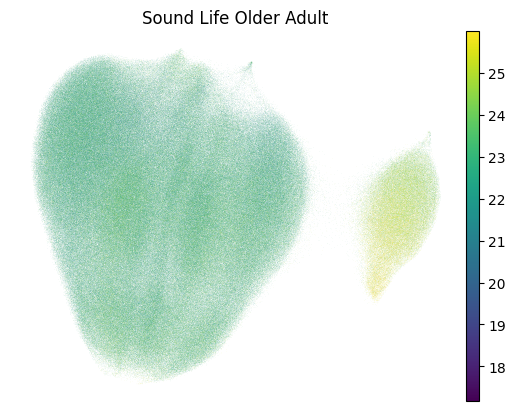

In [ ]:
import scanpy as sc
import numpy as np

def plot_cohort(cohort):

  test_adata = model.adata[model.adata.obs[(model.adata.obs['flu_sample']!='Day 90') & \
        (model.adata.obs['subject.ageGroup']==cohort)].index, :].copy()

  test_adata.obs['vacc_eff_size'] = flu_results[cohort]['all'].sel(\
                                    covariate='flu_sample_Day 7')['effect_size']

  sc.pl.umap(
      test_adata,
      color=["vacc_eff_size"],
      frameon=False,
      ncols=1,
      vmax=np.quantile(flu_results[cohort]['all'].effect_size.values, 0.95),
      cmap="viridis", title = cohort
  )
plot_cohort('Sound Life Young Adult')
plot_cohort('Sound Life Older Adult')

and stripplots by cell type

In [ ]:

## probably a better way to pull these results
young_adata = model.adata[model.adata.obs[(model.adata.obs['flu_sample']!='Day 90') & \
        (model.adata.obs['subject.ageGroup']=='Sound Life Young Adult')].index, :].copy()
young_adata.obs['vacc_eff_size'] = flu_results['Sound Life Young Adult']['all'].sel(\
                                    covariate='flu_sample_Day 7')['effect_size']
old_adata = model.adata[model.adata.obs[(model.adata.obs['flu_sample']!='Day 90') & \
        (model.adata.obs['subject.ageGroup']=='Sound Life Older Adult')].index, :].copy()
old_adata.obs['vacc_eff_size'] = flu_results['Sound Life Older Adult']['all'].sel(\
                                    covariate='flu_sample_Day 7')['effect_size']

plotdf = young_adata.obs[['AIFI_L3', 'partition','vacc_eff_size']].copy()
plotdf['cohort'] = 'Sound Life Young Adult'
plotdf = pd.concat([plotdf, old_adata.obs[['AIFI_L3', 'partition','vacc_eff_size']].copy()])
plotdf['cohort'] = plotdf['cohort'].fillna('Sound Life Older Adult')

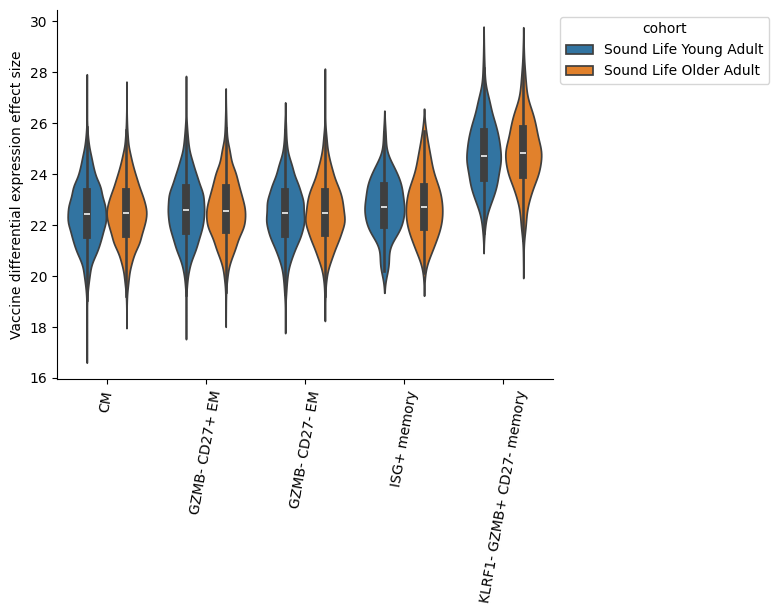

In [ ]:
plotdf['cell type'] = plotdf['AIFI_L3'].apply(lambda x: x[:-11])
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
sns.violinplot(data = plotdf.iloc[::100], x = 'cell type', y = 'vacc_eff_size', hue = 'cohort',
              dodge=True)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xticks(rotation = 80)
sns.despine()
plt.ylabel('Vaccine differential expression effect size')
plt.xlabel('')
plt.show()

### try to pick genes

In [ ]:
import numpy as np
import scipy.sparse as sp
from scipy.stats import rankdata
from tqdm import tqdm

# pull out highly variable genes
test_adata = old_adata

of_interest_genes = test_adata.var[
    test_adata.var["highly_variable_rank"] < 100
].index
gene_idx = test_adata.var_names.get_indexer(of_interest_genes)
X = test_adata.X[:, gene_idx]
n_cells, n_genes = X.shape

## rank within cells
ranks = np.full((n_cells, n_genes), np.nan, dtype=np.float32)

for i in tqdm(range(n_cells)):
    row = X.getrow(i)
    if row.nnz == 0:
        continue
    order = np.argsort(-row.data)
    ranks[i, row.indices[order]] = np.arange(row.nnz)

ranks = pd.DataFrame(ranks, index = test_adata.obs.index)
ranks.columns = of_interest_genes
ranks = ranks.join(test_adata.obs[['AIFI_L3', 'flu_sample']])


100%|██████████| 1213628/1213628 [00:50<00:00, 24100.46it/s]


In [ ]:
import numpy as np
import scipy.sparse as sp
from scipy.stats import rankdata
from tqdm import tqdm
from scipy.stats import ranksums, ttest_ind

def get_ranks(test_adata):

  of_interest_genes = test_adata.var[
      test_adata.var["highly_variable_rank"] < 100
  ].index
  gene_idx = test_adata.var_names.get_indexer(of_interest_genes)
  X = test_adata.X[:, gene_idx]
  n_cells, n_genes = X.shape

  ## rank within cells
  ranks = np.full((n_cells, n_genes), np.nan, dtype=np.float32)

  for i in tqdm(range(n_cells)):
      row = X.getrow(i)
      if row.nnz == 0:
          continue
      order = np.argsort(-row.data)
      ranks[i, row.indices[order]] = np.arange(row.nnz)

  ranks = pd.DataFrame(ranks, index = test_adata.obs.index)
  ranks.columns = of_interest_genes
  ranks = ranks.join(test_adata.obs[['AIFI_L3', 'flu_sample']])

  ## run t tests
  rankresults = []
  for gene in tqdm(of_interest_genes):
    d0= ranks[(ranks['AIFI_L3']=='GZMB- CD27+ EM CD4 T cell') & \
                        (ranks['flu_sample'] == 'Day 0')][gene].dropna()
    d7 = ranks[(ranks['AIFI_L3']=='GZMB- CD27+ EM CD4 T cell') & \
                        (ranks['flu_sample'] == 'Day 7')][gene].dropna()

    res = ttest_ind(d0,d7)
    change = np.mean(d7) - np.mean(d0)
    total = len(d0) + len(d7)

    rankresults.append([gene, change, res[0], res[1], total])
  rankresults = pd.DataFrame(rankresults, columns = ['gene', 'difference',
                                't', 'p', 'n'])
  return ranks, rankresults

old_ranks, old_rankresults = get_ranks(old_adata)
young_ranks, young_rankresults = get_ranks(young_adata)



 19%|█▉        | 19/100 [00:05<00:22,  3.68it/s]/usr/local/lib/python3.12/dist-packages/scipy/_lib/deprecation.py:234: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)
 22%|██▏       | 22/100 [00:04<00:15,  5.01it/s]/usr/local/lib/python3.12/dist-packages/scipy/_lib/deprecation.py:234: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)
 74%|███████▍  | 74/100 [00:15<00:05,  4.96it/s]/usr/local/lib/python3.12/dist-packages/scipy/stats/_stats_py.py:6316: RuntimeWarning: invalid value encountered in scalar divide
  Ttest_indResult(statistic=-0.5627187905196761, pvalue=0.5739887114209541)
100%|██████████| 100/100 [00:20<00:00,  4.90it/s]


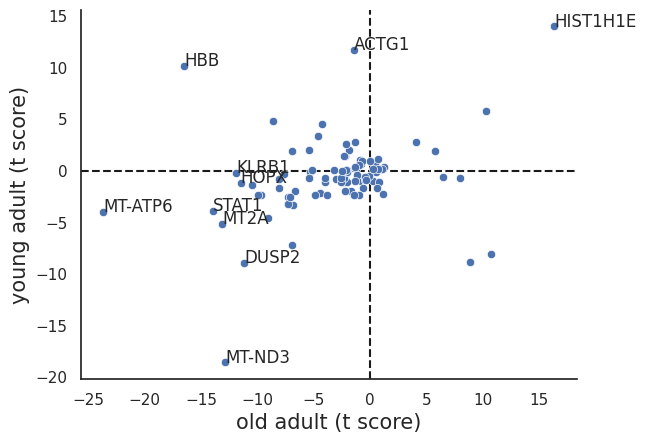

In [ ]:
sns.set(style='white', font_scale = 1)
plotdf = young_rankresults.set_index('gene').rename(columns = {'t': 'young_t'})[['young_t']].join(
    old_rankresults.set_index('gene').rename(columns = {'t': 'old_t'})[['old_t']])
plotdf['absmax'] = np.abs(plotdf).apply(np.max, axis = 1)
fig, ax = plt.subplots()
plt.axhline(0, linestyle = '--',color ='k', zorder = -1)
plt.axvline(0, linestyle = '--',color ='k', zorder = -1)
sns.scatterplot(data = plotdf,
                x = 'young_t', y = 'old_t')
plt.xlabel('old adult (t score)', fontsize=15)
plt.ylabel('young adult (t score)', fontsize=15)

for i, gene in enumerate(plotdf.sort_values(by = 'absmax', ascending=False).head(10).index):
  plt.annotate(gene, (plotdf.loc[gene, 'young_t'], plotdf.loc[gene, 'old_t']))

sns.despine()
plt.show()



In [ ]:
plotdf.sort_values(by = 'absmax', ascending=False).corr(method ='spearman')

,young_t,old_t,absmax
young_t,1.000000,0.331220,-0.621809
old_t,0.331220,1.000000,-0.289788
absmax,-0.621809,-0.289788,1.000000


In [ ]:
rankresults['abs_diff']= rankresults['difference'].apply(np.abs)

In [ ]:
rankresults[(rankresults['n'] > 1000) &\
        (rankresults['p']<0.001)].sort_values(by = 'abs_diff', ascending=False).head(5)

,gene,difference,t,p,n,abs_diff
51,HBB,-0.683573,10.145099,3.995143e-24,19663,0.683573
26,HIST1H1E,-0.330290,13.975704,2.313494e-44,180506,0.330290
10,DUSP2,0.324548,-8.922223,4.664965e-19,79083,0.324548
77,HBA2,-0.308998,3.356220,7.943032e-04,7102,0.308998
6,LINC01871,0.300400,-7.238895,4.578237e-13,59265,0.300400


In [ ]:
top_genes = rankresults[(rankresults['n'] > 1000) &\
        (rankresults['p']<0.001)].sort_values(by = 'abs_diff', ascending=False).head(5)['gene']


/tmp/ipython-input-1635636746.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.heatmap(ranks[ranks['flu_sample']=='Day 7'].groupby('cell type')[top_genes].mean() -\
/tmp/ipython-input-1635636746.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ranks[ranks['flu_sample']=='Day 0'].groupby('cell type')[top_genes].mean())


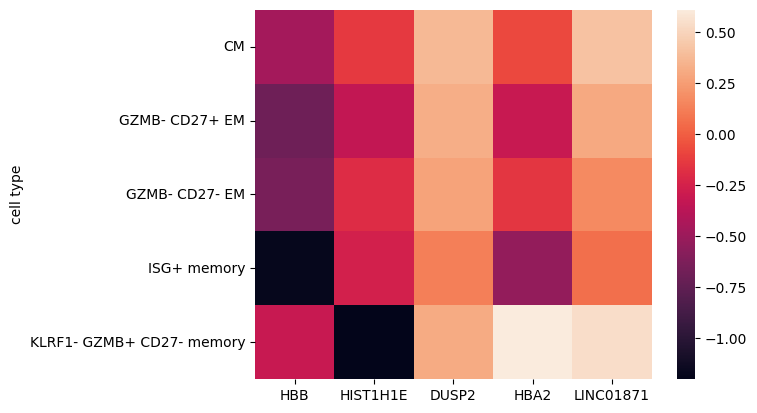

In [ ]:
ranks['cell type'] = ranks['AIFI_L3'].apply(lambda x: x[:-11])
sns.heatmap(ranks[ranks['flu_sample']=='Day 7'].groupby('cell type')[top_genes].mean() -\
  ranks[ranks['flu_sample']=='Day 0'].groupby('cell type')[top_genes].mean())
plt.show()

/tmp/ipython-input-1197541838.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.heatmap(ranks[ranks['flu_sample']=='Day 7'].groupby('AIFI_L3')[top_genes].mean() -\
/tmp/ipython-input-1197541838.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ranks[ranks['flu_sample']=='Day 0'].groupby('AIFI_L3')[top_genes].mean())


<Axes: ylabel='AIFI_L3'>

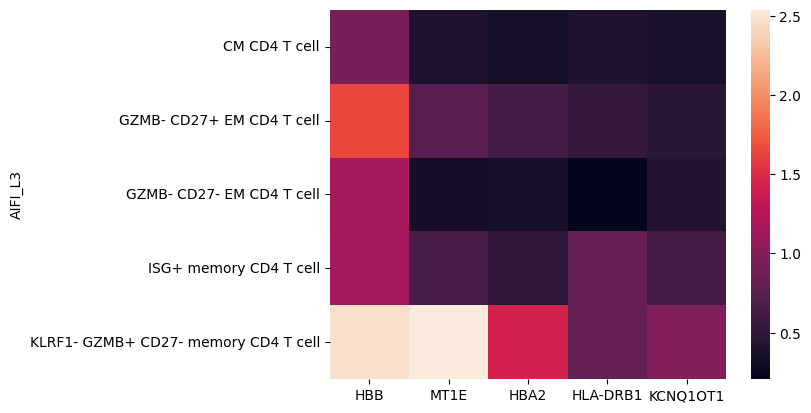

In [ ]:
pdf = ranks.groupby(['AIFI_L3', 'flu_sample'])[top_genes].mean().reset_index()
pdf

/tmp/ipython-input-1624816054.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pdf = ranks.groupby(['AIFI_L3', 'flu_sample'])[top_genes].mean().reset_index()


,AIFI_L3,flu_sample,HBB,MT1E,HBA2,HLA-DRB1,KCNQ1OT1
0,CM CD4 T cell,Day 0,13.869220,14.976155,14.833793,13.765661,13.947671
1,CM CD4 T cell,Day 7,14.789671,15.375488,15.182768,14.163424,14.312692
2,GZMB- CD27+ EM CD4 T cell,Day 0,16.510862,17.712214,17.551126,17.460754,16.960260
3,GZMB- CD27+ EM CD4 T cell,Day 7,18.151823,18.461895,18.171858,17.976564,17.435425
4,GZMB- CD27- EM CD4 T cell,Day 0,15.277327,16.574213,15.945188,14.595711,15.338551
5,GZMB- CD27- EM CD4 T cell,Day 7,16.445091,16.911629,16.300884,14.801643,15.769188
6,ISG+ memory CD4 T cell,Day 0,16.058577,17.201717,17.600000,15.874886,16.419397
7,ISG+ memory CD4 T cell,Day 7,17.207100,17.862434,18.100000,16.690954,17.038759
8,KLRF1- GZMB+ CD27- memory CD4 T cell,Day 0,24.238865,22.674747,23.872597,22.063875,24.427803
9,KLRF1- GZMB+ CD27- memory CD4 T cell,Day 7,26.707390,25.213367,25.298246,22.874758,25.406113


In [ ]:
sns.barplot( data = pd.melt(ranks.groupby(['AIFI_L3', 'flu_sample'])[top_genes].mean().reset_index(),
        id_vars = ['AIFI_L3', 'flu_sample'], value_vars = top_genes, var_name = 'gene', value_name='avg_rank'),
             x = 'AIFI_L3', y = 'avg_rank', hue = 'flu_sample')


/tmp/ipython-input-429634383.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pd.melt(ranks.groupby(['AIFI_L3', 'flu_sample'])[top_genes].mean().reset_index(),


,AIFI_L3,flu_sample,gene,avg_rank
0,CM CD4 T cell,Day 0,HBB,13.869220
1,CM CD4 T cell,Day 7,HBB,14.789671
2,GZMB- CD27+ EM CD4 T cell,Day 0,HBB,16.510862
3,GZMB- CD27+ EM CD4 T cell,Day 7,HBB,18.151823
4,GZMB- CD27- EM CD4 T cell,Day 0,HBB,15.277327
5,GZMB- CD27- EM CD4 T cell,Day 7,HBB,16.445091
6,ISG+ memory CD4 T cell,Day 0,HBB,16.058577
7,ISG+ memory CD4 T cell,Day 7,HBB,17.207100
8,KLRF1- GZMB+ CD27- memory CD4 T cell,Day 0,HBB,24.238865
9,KLRF1- GZMB+ CD27- memory CD4 T cell,Day 7,HBB,26.707390
